# Assignment 4: Wheres Waldo?
### Name: Eileanor LaRocco
In this assignment, you will develop an object detection algorithm to locate Waldo in a set of images. You will develop a model to detect the bounding box around Waldo. Your final task is to submit your predictions on Kaggle for evaluation.

### Process/Issues
- Double-checked that the images we were given were correctly bounded (did this by visualizing the boxes on the images - they look good!)
- Complication: Originally when I creating augmented images, the bounding box labels did not also augment. I also had to try out a few types of augmentation to see what made sense for waldo. The augmented images may still not be as different from one another as they could be which could allow the model to favor the training images that occur more frequently.
- Complication: Similarly, when resizing the images, ensuring the bounding boxes not only are also adjusted if necessary, but ensuring they do not get cut off and the image is not stretched/shrunk too much.

### Imports

In [31]:
import os
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt



from PIL import Image
from torchvision.io import read_image
from tqdm import tqdm
import opendatasets as od
import cv2
import albumentations as A
import random
import shutil
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import functional as Fu
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [32]:
SEED = 1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = device = torch.device("mps")
print(device)

mps


### Download Data

In [33]:
od.download('https://www.kaggle.com/competitions/2024-fall-ml-3-hw-4-wheres-waldo/data')

Skipping, found downloaded files in "./2024-fall-ml-3-hw-4-wheres-waldo" (use force=True to force download)


### Paths

In [34]:
train_folder = "2024-fall-ml-3-hw-4-wheres-waldo/train/train" # Original Train Images
test_folder = "2024-fall-ml-3-hw-4-wheres-waldo/test/test" # Original Test Images
annotations_file = "2024-fall-ml-3-hw-4-wheres-waldo/annotations.csv" # Original Annotations File

# Preprocess Images (Crop/Augment)

### Check Image Sizes

In [35]:
# Train Images

# Iterate over all images in the folder
for image_name in os.listdir(train_folder):
    if image_name.endswith((".jpg")):  # Check for common image extensions
        image_path = os.path.join(train_folder, image_name)
        
        # Read the image using OpenCV
        img = cv2.imread(image_path)
        if img is not None:
            height, width, channels = img.shape  # Get image size (height, width, channels)
            print(f"Image: {image_name}, Width: {width}, Height: {height}")
        else:
            print(f"Could not read image: {image_name}")

# Test Images

# Iterate over all images in the folder
for image_name in os.listdir(test_folder):
    if image_name.endswith((".jpg")):  # Check for common image extensions
        image_path = os.path.join(test_folder, image_name)
        
        # Read the image using OpenCV
        img = cv2.imread(image_path)
        if img is not None:
            height, width, channels = img.shape  # Get image size (height, width, channels)
            print(f"Image: {image_name}, Width: {width}, Height: {height}")
        else:
            print(f"Could not read image: {image_name}")


Image: 8.jpg, Width: 2800, Height: 1760
Image: 9.jpg, Width: 1298, Height: 951
Image: 14.jpg, Width: 1700, Height: 2340
Image: 15.jpg, Width: 1600, Height: 1006
Image: 17.jpg, Width: 1599, Height: 1230
Image: 16.jpg, Width: 1525, Height: 3415
Image: 12.jpg, Width: 1276, Height: 1754
Image: 13.jpg, Width: 1280, Height: 864
Image: 11.jpg, Width: 2828, Height: 1828
Image: 10.jpg, Width: 1600, Height: 980
Image: 21.jpg, Width: 2048, Height: 1515
Image: 20.jpg, Width: 2953, Height: 2088
Image: 22.jpg, Width: 500, Height: 256
Image: 23.jpg, Width: 325, Height: 300
Image: 27.jpg, Width: 591, Height: 629
Image: 26.jpg, Width: 600, Height: 374
Image: 18.jpg, Width: 1590, Height: 981
Image: 24.jpg, Width: 456, Height: 256
Image: 25.jpg, Width: 413, Height: 500
Image: 19.jpg, Width: 1280, Height: 864
Image: 4.jpg, Width: 2048, Height: 1272
Image: 5.jpg, Width: 2100, Height: 1760
Image: 7.jpg, Width: 1949, Height: 1419
Image: 6.jpg, Width: 2048, Height: 1454
Image: 2.jpg, Width: 1286, Height: 946


### Resize Images

In [36]:
# Paths
resized_folder = "2024-fall-ml-3-hw-4-wheres-waldo/train/train/resized"
resized_annotations_file = "2024-fall-ml-3-hw-4-wheres-waldo/resized_annotations.csv"
target_size = (128, 128)  # Target size for resizing images

# Read the annotations CSV file
annotations_df = pd.read_csv(annotations_file)

# Create the output folder if it doesn't exist
os.makedirs(resized_folder, exist_ok=True)

# List to store updated bounding boxes
updated_annotations = []

# Iterate over all images in the annotation file
for index, row in annotations_df.iterrows():
    image_name = row["filename"]
    xmin, ymin, xmax, ymax = row["xmin"], row["ymin"], row["xmax"], row["ymax"]
    
    # Load the image
    image_path = os.path.join(train_folder, image_name)
    img = cv2.imread(image_path)
    
    if img is not None:
        original_height, original_width = img.shape[:2]
        
        # Calculate the resizing scale factors
        scale_x = target_size[0] / original_width
        scale_y = target_size[1] / original_height
        
        # Resize the image
        resized_img = cv2.resize(img, target_size)
        
        # Adjust bounding boxes based on the scaling factors
        xmin_new = int(xmin * scale_x)
        ymin_new = int(ymin * scale_y)
        xmax_new = int(xmax * scale_x)
        ymax_new = int(ymax * scale_y)
        
        # Save the resized image
        resized_image_path = os.path.join(resized_folder, image_name)
        cv2.imwrite(resized_image_path, resized_img)
        
        # Add the updated annotation to the list
        updated_annotations.append([image_name, xmin_new, ymin_new, xmax_new, ymax_new])

# Save the updated annotations to a new CSV file
updated_annotations_df = pd.DataFrame(updated_annotations, columns=["filename", "xmin", "ymin", "xmax", "ymax"])
updated_annotations_df.to_csv(resized_annotations_file, index=False)

print("Images and annotations resized and saved.")


Images and annotations resized and saved.


In [ ]:
def filter_csv_by_column(input_csv, output_csv, column_name, values_list):
    """
    Filters rows in a CSV file and keeps only those where the specified column's value is in a given list.

    Parameters:
        input_csv (str): Path to the input CSV file.
        output_csv (str): Path to save the filtered CSV file.
        column_name (str): Column to filter on.
        values_list (list): List of values to keep.
    """
    # Load the CSV into a DataFrame
    df = pd.read_csv(input_csv)

    # Filter the DataFrame
    filtered_df = df[df[column_name].isin(values_list)]

    # Save the filtered DataFrame to a new CSV file
    filtered_df.to_csv(output_csv, index=False)

In [55]:
import shutil

def split_directory(source_dir, target_dir, file_list):
    """Splits files from source_dir to target_dir based on file_list."""

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    for file_name in file_list:
        source_path = os.path.join(source_dir, file_name)
        target_path = os.path.join(target_dir, file_name)

        if os.path.exists(source_path):
            shutil.move(source_path, target_path)
            print(f"Moved: {file_name}")
        else:
            print(f"File not found: {file_name}")

if __name__ == "__main__":
    source_dir = train_folder
    target_dir = "2024-fall-ml-3-hw-4-wheres-waldo/train/val"
    file_list = list(val_images)

    split_directory(source_dir, target_dir, file_list)

Moved: 18.jpg
Moved: 5.jpg
Moved: 19.jpg
Moved: 22.jpg
Moved: 1.jpg
Moved: 3.jpg


In [56]:
# Split training data into train and validation sets
annotations = pd.read_csv(annotations_file)
image_files = annotations["filename"].unique()
train_images, val_images = train_test_split(image_files, test_size=0.2, random_state=42)

In [57]:
def filter_csv_by_column(input_csv, output_csv, column_name, values_list):
    """
    Filters rows in a CSV file and keeps only those where the specified column's value is in a given list.

    Parameters:
        input_csv (str): Path to the input CSV file.
        output_csv (str): Path to save the filtered CSV file.
        column_name (str): Column to filter on.
        values_list (list): List of values to keep.
    """
    # Load the CSV into a DataFrame
    df = pd.read_csv(input_csv)

    # Filter the DataFrame
    filtered_df = df[df[column_name].isin(values_list)]

    # Save the filtered DataFrame to a new CSV file
    filtered_df.to_csv(output_csv, index=False)

In [58]:
#split annotations into train and val
values_list = list(train_images)

# Example usage
output_csv = "2024-fall-ml-3-hw-4-wheres-waldo/train_annotations.csv"  # Replace with your output file path
column_name = "filename"  # Replace with the column you want to filter

filter_csv_by_column(annotations_file, output_csv, column_name, values_list)




values_list = list(val_images)

# Example usage
output_csv = "2024-fall-ml-3-hw-4-wheres-waldo/test_annotations.csv"  # Replace with your output file path
column_name = "filename"  # Replace with the column you want to filter

filter_csv_by_column(annotations_file, output_csv, column_name, values_list)



In [ ]:
import shutil

def split_directory(source_dir, target_dir, file_list):
    """Splits files from source_dir to target_dir based on file_list."""

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    for file_name in file_list:
        source_path = os.path.join(source_dir, file_name)
        target_path = os.path.join(target_dir, file_name)

        if os.path.exists(source_path):
            shutil.move(source_path, target_path)
            print(f"Moved: {file_name}")
        else:
            print(f"File not found: {file_name}")

if __name__ == "__main__":
    source_dir = train_folder
    target_dir = "2024-fall-ml-3-hw-4-wheres-waldo/train/val"
    file_list = list(val_images)

    split_directory(source_dir, target_dir, file_list)

# Preprocessing (for model)

In [37]:
# Paths
train_dir = "datasets/dataset/train"
val_dir = "datasets/dataset/val"

#Saved Predictions
test_dir = "test_predictions"

# Create necessary folders
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Load annotations
annotations = pd.read_csv(resized_annotations_file)

# Function to convert annotations to correct format
def convert_to_format(row, img_width, img_height):
    x_center = (row["xmin"] + row["xmax"]) / 2 / img_width
    y_center = (row["ymin"] + row["ymax"]) / 2 / img_height
    width = (row["xmax"] - row["xmin"]) / img_width
    height = (row["ymax"] - row["ymin"]) / img_height
    return f"0 {x_center} {y_center} {width} {height}"

# Split training data into train and validation sets
image_files = annotations["filename"].unique()
train_images, val_images = train_test_split(image_files, test_size=0.2, random_state=42)

# Function to prepare format data
def prepare_data(image_list, output_dir):
    for img_name in image_list:
        img_path = os.path.join(resized_folder, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img_height, img_width, _ = img.shape

        # Filter annotations for this image
        image_annotations = annotations[annotations["filename"] == img_name]

        # Annotations file
        x_annotations = []
        for _, row in image_annotations.iterrows():
            lne = convert_to_format(row, img_width, img_height)
            x_annotations.append(lne)

        # Save image and annotation
        base_name = os.path.splitext(img_name)[0]
        shutil.copy(img_path, os.path.join(output_dir, f"{base_name}.jpg"))
        with open(os.path.join(output_dir, f"{base_name}.txt"), "w") as f:
            f.write("\n".join(x_annotations))

# Prepare training and validation data
prepare_data(train_images, train_dir)
prepare_data(val_images, val_dir)


In [ ]:
#split annotations into train and val
values_list = []
directory = "datasets/dataset/train"
for filename in os.listdir(directory):
    if filename.endswith('.jpg'):
        values_list.append(filename)

# Example usage
input_csv = "2024-fall-ml-3-hw-4-wheres-waldo/resized_annotations.csv"
column_name = "filename"

#Get Train Boxes
train_boxes = []
df = pd.read_csv(input_csv)
filtered_df = df[df[column_name].isin(values_list)]
for row in range(len(filtered_df)):
    #print(f'{filtered_df.iloc[row, 0]}')
    row_list = filtered_df.iloc[row, 1:].tolist()
    train_boxes.append(row_list) 
print(len(train_boxes))

#Get Train Images
train_images = []
df = pd.read_csv(input_csv)
filtered_df = df[df[column_name].isin(values_list)]
for row in range(len(filtered_df)):
    filename = filtered_df.iloc[row, 0]
    img_path = os.path.join(directory, filename)
    image = Image.open(img_path).convert("RGB")
    image = Fu.to_tensor(image)   
    train_images.append(image) 
print(len(train_images))

28
28


In [40]:
#split annotations into train and val
values_list = []
directory = "datasets/dataset/val"
for filename in os.listdir(directory):
    if filename.endswith('.jpg'):
        values_list.append(filename)

# Example usage
input_csv = "2024-fall-ml-3-hw-4-wheres-waldo/resized_annotations.csv"
column_name = "filename"

#Get Train Boxes
test_boxes = []
df = pd.read_csv(input_csv)
filtered_df = df[df[column_name].isin(values_list)]
for row in range(len(filtered_df)):
    #print(f'{filtered_df.iloc[row, 0]}')
    row_list = filtered_df.iloc[row, 1:].tolist()
    test_boxes.append(row_list) 
print(len(test_boxes))

#Get Train Images
test_images = []
df = pd.read_csv(input_csv)
filtered_df = df[df[column_name].isin(values_list)]
for row in range(len(filtered_df)):
    filename = filtered_df.iloc[row, 0]
    img_path = os.path.join(directory, filename)
    image = Image.open(img_path).convert("RGB")
    image = Fu.to_tensor(image)   
    test_images.append(image) 
print(len(test_images))

6
6


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Custom Dataset Class
class BoundingBoxDataset(Dataset):
    def __init__(self, images, boxes):
        """
        Args:
            images (numpy array or torch tensor): The images as a tensor of shape (N, 3, 128, 128)
            boxes (numpy array or torch tensor): The corresponding bounding boxes of shape (N, 4)
        """
        self.images = images
        self.boxes = boxes

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        box = self.boxes[idx]
        return image, box

# Create Dataset and DataLoader
train_dataset = BoundingBoxDataset(train_images, train_boxes)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = BoundingBoxDataset(test_images, test_boxes)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [54]:
#Train
directory = "datasets/yolo_dataset/train"

#Train Images
def get_image_files_content(directory):
    images = []
   # Get all .txt files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.jpg'):
            img_path = os.path.join(directory, filename)
            image = Image.open(img_path).convert("RGB")
            image = F.to_tensor(image)
            images.append(image)

    targets = []
    # Get all .txt files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            file_path = os.path.join(directory, filename)
            
            # Read the file and append its content as a list of lines
            with open(file_path, 'r') as file:
                lines = file.readlines()
                targets.append([line.strip() for line in lines])  # Strip newlines

    return images, targets

train_images, train_targets = get_image_files_content(directory)



#Test
directory = "datasets/yolo_dataset/val"

#Train Images
def get_image_files_content(directory):
    images = []
   # Get all .txt files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.jpg'):
            img_path = os.path.join(directory, filename)
            image = Image.open(img_path).convert("RGB")
            image = F.to_tensor(image)
            images.append(image)

    targets = []
    # Get all .txt files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            file_path = os.path.join(directory, filename)
            
            # Read the file and append its content as a list of lines
            with open(file_path, 'r') as file:
                lines = file.readlines()
                targets.append([line.strip() for line in lines])  # Strip newlines

    return images, targets

test_images, test_targets = get_image_files_content(directory)


FileNotFoundError: [Errno 2] No such file or directory: 'datasets/yolo_dataset/train'

In [ ]:
class WaldoDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir, transforms=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        image = Fu.to_tensor(image)
        
        # Read bounding box data, ensuring all are converted to float
        box_data = self.img_labels.iloc[idx, 4:8].values
        boxes = []
        for item in box_data:
            try:
                boxes.append(float(item))
            except ValueError as e:
                raise ValueError(f"Error converting bounding box data to float: {e}")

        # Create tensors
        boxes = torch.as_tensor([boxes], dtype=torch.float32)
        labels = torch.ones((1,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((1,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target


# Example usage:
# Create the dataset
train_dataset = WaldoDataset(annotations_file= "2024-fall-ml-3-hw-4-wheres-waldo/resized_annotations.csv", img_dir="datasets/dataset/train")
#val_dataset = WaldoDataset(annotations_file= 'path/to/val_annotation.csv', img_dir='path/to/val')

# Now, you can use this dataset with a DataLoader to train your model
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x))
)


# Model

### Architecture

In [43]:
class SimpleBBoxModel(nn.Module):
    def __init__(self):
        super(SimpleBBoxModel, self).__init__()
        
        # Define a simple CNN architecture
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        # Define a fully connected layer to output 4 values for the bounding box
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # Flattening 64 channels of 16x16 feature maps
        self.fc2 = nn.Linear(128, 4)  # Outputting the 4 bounding box coordinates

    def forward(self, x):
        # Pass the input through the convolutional layers
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # Pooling to reduce the spatial dimensions
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)  # Pooling again
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)  # Final pooling
        
        # Flatten the output for the fully connected layer
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        
        # Pass through the fully connected layers
        x = F.relu(self.fc1(x))
        bbox = self.fc2(x)  # Output 4 values for the bounding box
        
        return bbox

# Example usage:
model = SimpleBBoxModel()

# Input a batch of 128x128 RGB images (batch_size=2)
images = torch.randn(2, 3, 128, 128)  # Random images for demonstration

# Forward pass
output = model(images)
print("Bounding box predictions: ", output)


Bounding box predictions:  tensor([[0.0096, 0.0707, 0.0660, 0.0911],
        [0.0207, 0.0816, 0.0805, 0.0981]], grad_fn=<AddmmBackward0>)


### Training

In [53]:
# Model, Loss, Optimizer
model = SimpleBBoxModel()
criterion = nn.L1Loss()  # You can use L1 or MSE Loss for bounding box regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, targets in train_loader:
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            print(outputs)
            print(len(outputs))
            print(targets)
            print(len(targets))


            # Calculate loss
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Evaluation Loop
def evaluate(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    with torch.no_grad():  # No need to calculate gradients during evaluation
        for images, targets in test_loader:
            outputs = model(images)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Evaluation Loss: {avg_loss:.4f}")

# Train the model
train(model, train_loader, criterion, optimizer, num_epochs=10)

# Evaluate the model
evaluate(model, train_loader, criterion)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/elarocco/Desktop/uva_phd_2024/wheres_waldo/datasets/dataset/train/3.jpg'

In [45]:
torch.randn(3, 5)

tensor([[-1.8655, -1.7041,  1.4905, -0.9767,  0.4818],
        [ 0.0835,  0.2439, -0.8490, -0.1204, -0.7448],
        [ 0.6298, -0.4835, -0.0051, -0.5406, -0.5364]])

In [ ]:
#images.shape #torch.Size([x, 3, 128, 128]) - list of image tensors
#boxes.shape #torch.Size([100, 4]) - list of bounding box lists (len 4)

torch.Size([100, 4])

Predicted Bounding Box: [  -0.021366     0.05111    -0.09962    0.019611]


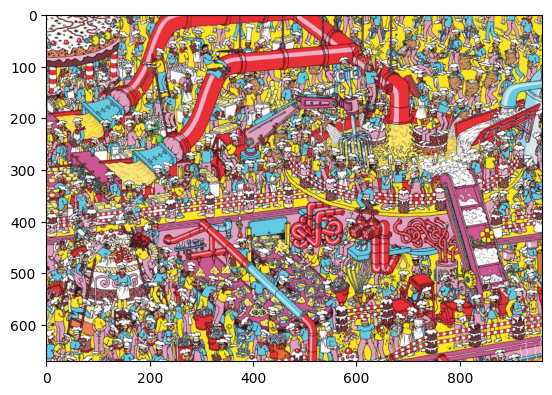

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

# Function to predict bounding box on a new image
def predict(model, image_path, transform=None):
    model.eval()  # Set the model to evaluation mode

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")  # Open image and convert to RGB
    if transform:
        image = transform(image)  # Apply transformations like resizing, normalization
    image = image.unsqueeze(0)  # Add batch dimension (1, 3, 128, 128)

    # Predict the bounding box
    with torch.no_grad():  # No need to calculate gradients during prediction
        predicted_bbox = model(image)  # Get predicted bounding box

    return predicted_bbox.squeeze().cpu().numpy()  # Remove batch dimension and return as numpy array

# Define image transformations (resize, normalization)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the image to 128x128
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the image
])

# Example usage for prediction on a new image
image_path = os.path.join(test_folder, '1.jpg')  # Replace with the path to your test image
predicted_bbox = predict(model, image_path, transform)

# Print the predicted bounding box (x_min, y_min, x_max, y_max)
print("Predicted Bounding Box:", predicted_bbox)

# Plot the image and the predicted bounding box
image = Image.open(image_path)
plt.imshow(image)
plt.gca().add_patch(plt.Rectangle(
    (predicted_bbox[0], predicted_bbox[1]),  # (x_min, y_min)
    predicted_bbox[2] - predicted_bbox[0],  # Width (x_max - x_min)
    predicted_bbox[3] - predicted_bbox[1],  # Height (y_max - y_min)
    linewidth=4, edgecolor='r', facecolor='none'
))
plt.show()


# Submission File 

In [ ]:
test_folder = "2024-fall-ml-3-hw-4-wheres-waldo/test/test"

# Predict on test images
test_images = [os.path.join(test_folder, img) for img in os.listdir(test_folder) if img.endswith(".jpg")]
results = model.predict(source=test_images, save=True, save_txt=True, project="yolo_test_predictions")

# Prepare to save the predictions
output_csv_path = os.path.join("yolo_test_predictions", "predictions.csv")
predictions = []

# Process results
for result in results:
    image_name = os.path.basename(result.path)  # Get the image name
    if result.boxes is not None and len(result.boxes) > 0:  # Check if there are predictions
        # Convert result.boxes to tensor for easier access
        boxes = result.boxes.xyxy.cpu().numpy()  # Convert bounding boxes to array
        confidences = result.boxes.conf.cpu().numpy()  # Convert confidence scores to array

        # Find the index of the box with the highest confidence
        best_idx = confidences.argmax()
        best_box = boxes[best_idx]
        conf = confidences[best_idx]

        # Extract bounding box coordinates
        x_min, y_min, x_max, y_max = best_box
        predictions.append([image_name, x_min, y_min, x_max, y_max, conf])
    else:
        # No predictions for this image
        predictions.append([image_name, None, None, None, None, None])

# Save predictions to CSV
df = pd.DataFrame(predictions, columns=["filename", "xmin", "ymin", "xmax", "ymax", "confidence"])
df.to_csv(output_csv_path, index=False)

print(f"Predictions saved to {output_csv_path}")



0: 640x640 (no detections), 210.5ms
1: 640x640 (no detections), 210.5ms
2: 640x640 (no detections), 210.5ms
3: 640x640 (no detections), 210.5ms
4: 640x640 (no detections), 210.5ms
5: 640x640 (no detections), 210.5ms
6: 640x640 (no detections), 210.5ms
7: 640x640 (no detections), 210.5ms
8: 640x640 (no detections), 210.5ms
Speed: 1.5ms preprocess, 210.5ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to yolo_test_predictions/train2
0 label saved to yolo_test_predictions/train2/labels
Predictions saved to yolo_test_predictions/predictions.csv
